# Cluster Analysis of BostonBlueBikes

In [69]:
import numpy as np
import pandas as pd
import folium
from math import sin, cos, pi
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt



## Load processed dataframe

In [ ]:
df_boston = pd.read_csv('./data/prepared/rides_data_prepared.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
df_boston.info()

In [ ]:
df_boston.head()

In [72]:
## todo cluster trip types/customer types
## cluster areas/station types (?) -> university, center ...
## cluster seasons and weather (?) 


## Clustering of trip types

### Data Prep and Scaling

##### We prepare a dataframe that simply includes time of rental as well as the trip length. We consider not only daytime but also the weekday the bike was rented. 

In [73]:
#features: hour, day, season?, duration

In [74]:
trip_types = df_boston[['start_time', 'end_time', 'trip_length']].copy()
trip_types.loc[:,'hour'] = trip_types['start_time'].apply( lambda x: x.hour + (x.minute/60))
trip_types.loc[:, 'weekday'] = trip_types['start_time'].apply(lambda x: x.day_of_week)
#trip_types.loc[:, 'season'] = trip_types['start_time'].apply(lambda x: x.month%12//3 +1)

In [75]:
trip_types = trip_types.rename(columns = {'trip_length' : 'duration_in_sec'})

In [ ]:
trip_types.head()

##### Include circular feature of time variables -> otherwise problem with standardization (why?)

In [77]:
def circular( name, feature, dataframe, n):
    dataframe[name + '_sin'] = feature.apply(lambda x: sin(2*pi*(x/n)))
    dataframe[name + '_cos'] = feature.apply(lambda x: cos(2*pi*(x/n)))

circular('hour', trip_types['hour'], trip_types, 24)
circular('weekday', trip_types['weekday'], trip_types, 7)
#circular('season', trip_types['season'], trip_types, 4)

X = trip_types.drop(['hour', 'weekday', 'start_time', 'end_time'], axis = 1)


In [ ]:
X.head()

##### Scaling variables to ensure same weights

In [95]:
scaler= StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns, index = X.index)
X_scaled_df

,duration_in_sec,hour_sin,hour_cos,weekday_sin,weekday_cos
0,-0.019441,0.527893,2.322666,0.519928,-1.193226
1,-0.022561,0.564513,2.317805,0.519928,-1.193226
2,-0.028000,0.588864,2.313892,0.519928,-1.193226
3,-0.022740,0.721567,2.282826,0.519928,-1.193226
4,-0.013734,0.804544,2.254743,0.519928,-1.193226
...,...,...,...,...,...
1122549,-0.020986,0.246075,2.319560,0.519928,-1.193226
1122550,-0.017539,0.258282,2.321180,0.519928,-1.193226
1122551,-0.019233,0.264389,2.321940,0.519928,-1.193226
1122552,-0.032013,0.313332,2.326806,0.519928,-1.193226


In [103]:
trip_types_scaled = X_scaled_df

In [ ]:
trip_types_scaled.head()

### Choose number of clusters (K): elbow method

In [82]:
k_max = 35 #35 is a reasonable maximum as there are 7 weekdays with five different daytimes each(morning, noon, afternoon, evening, night). 
clusters = []
losses = []

for k in range(k_max):
    model= MiniBatchKMeans(n_clusters=k+1,random_state=42,init="k-means++") 
    model.fit(X_scaled)
    clusters.append(k+1)
    losses.append(model.inertia_)


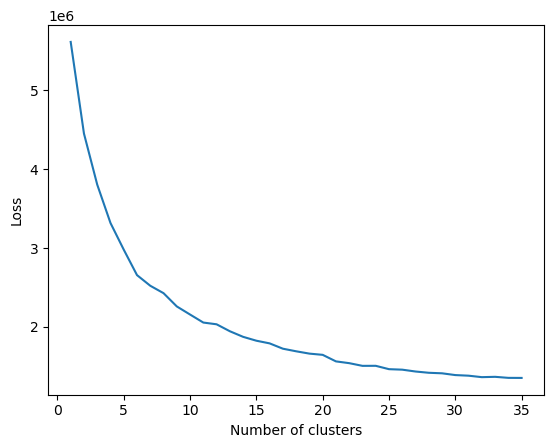

In [83]:
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.show()

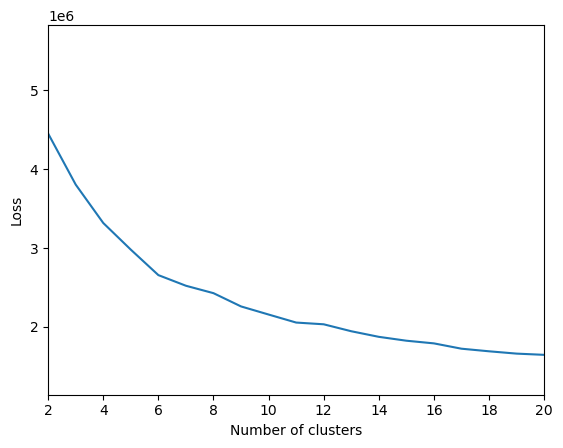

In [84]:
#zooming in on clusters between 0 and 15
plt.plot(clusters, losses)
plt.ylabel("Loss")
plt.xlabel("Number of clusters")
plt.xlim([2,20])
plt.show()

From this graph we inferr that a good amount of clusters lies within the range of 6-10, which is why we choose 8 as the 'optimal' amount of clusters. 

### Clustering

In [104]:
# refit algorithm
eight_means = MiniBatchKMeans(n_clusters=8, random_state=42,init="k-means++")
eight_means.fit(X_scaled)

numbers = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight']

#add cluster lables to the dataset
trip_types_scaled["cluster_eight"] = eight_means.predict(X_scaled)
trip_types_scaled["cluster_eight"] = trip_types_scaled["cluster_eight"].apply(lambda x: numbers[x])

trip_types_scaled['hour'] = trip_types.hour
trip_types_scaled['weekday'] = trip_types.weekday
trip_types_scaled['duration_in_sec'] = trip_types.duration_in_sec


In [105]:
trip_types_scaled.head()

,duration_in_sec,hour_sin,hour_cos,weekday_sin,weekday_cos,hour,weekday,cluster_eight
0,543.0,0.527893,2.322666,0.519928,-1.193226,0.350000,3,five
1,438.0,0.564513,2.317805,0.519928,-1.193226,0.450000,3,five
2,255.0,0.588864,2.313892,0.519928,-1.193226,0.516667,3,five
3,432.0,0.721567,2.282826,0.519928,-1.193226,0.883333,3,five
4,735.0,0.804544,2.254743,0.519928,-1.193226,1.116667,3,five


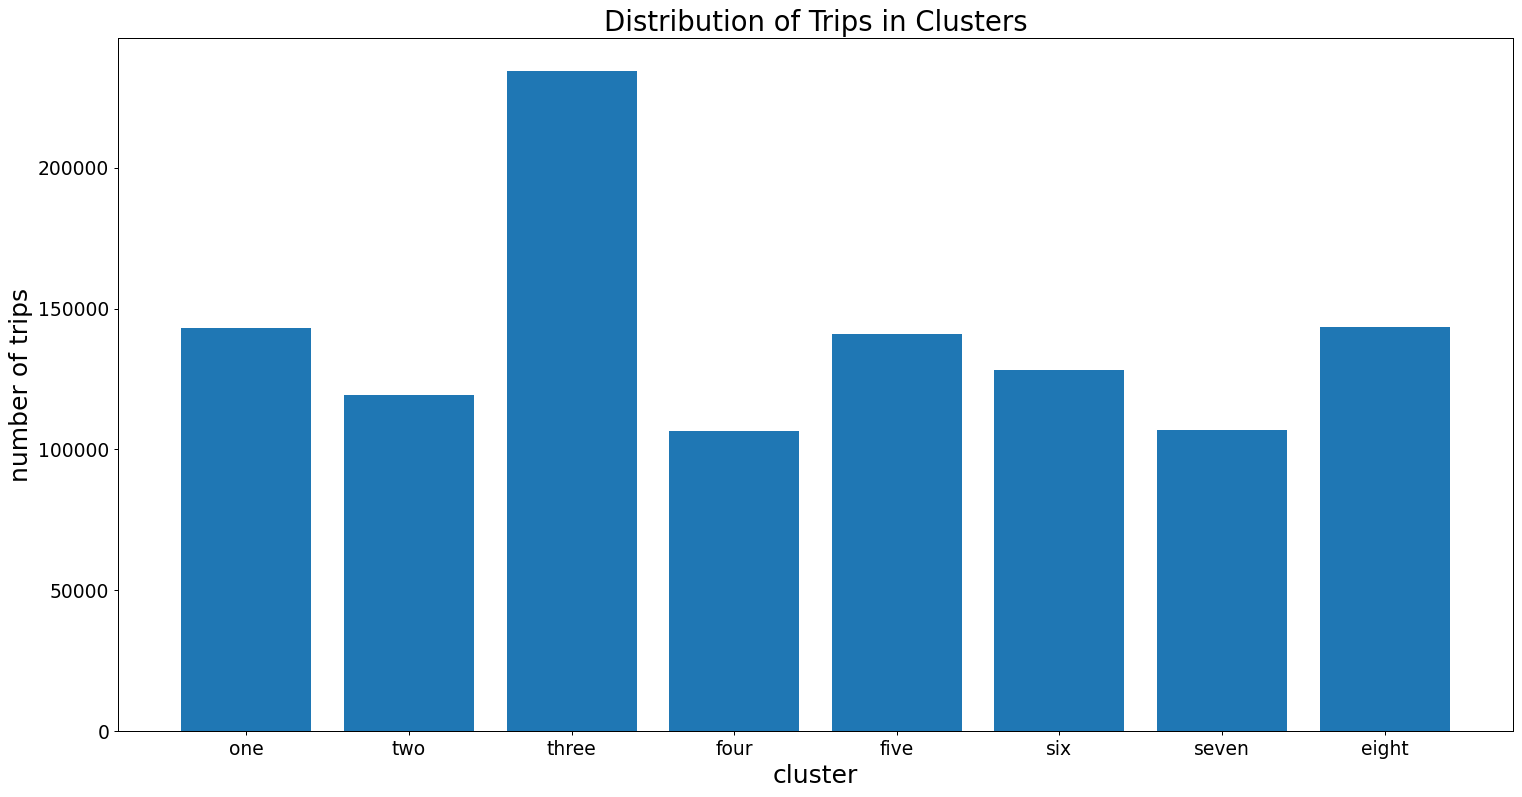

In [106]:
count = [len(trip_types_scaled[trip_types_scaled.cluster_eight==numbers[i]]) for i in range(len(numbers))]

fig,ax = plt.subplots(figsize=(20,10), dpi=90) 
axis_font = {'size':'20'}
label_font = {'labelsize':'15'}
dic={'fontsize': '22'}

ax.set_title("Distribution of Trips in Clusters", dic)
ax.set_ylabel("number of trips", **axis_font)
ax.set_xlabel("cluster", **axis_font)
ax.tick_params(axis='both', **label_font)
    
plt.bar(numbers,count)
plt.show()

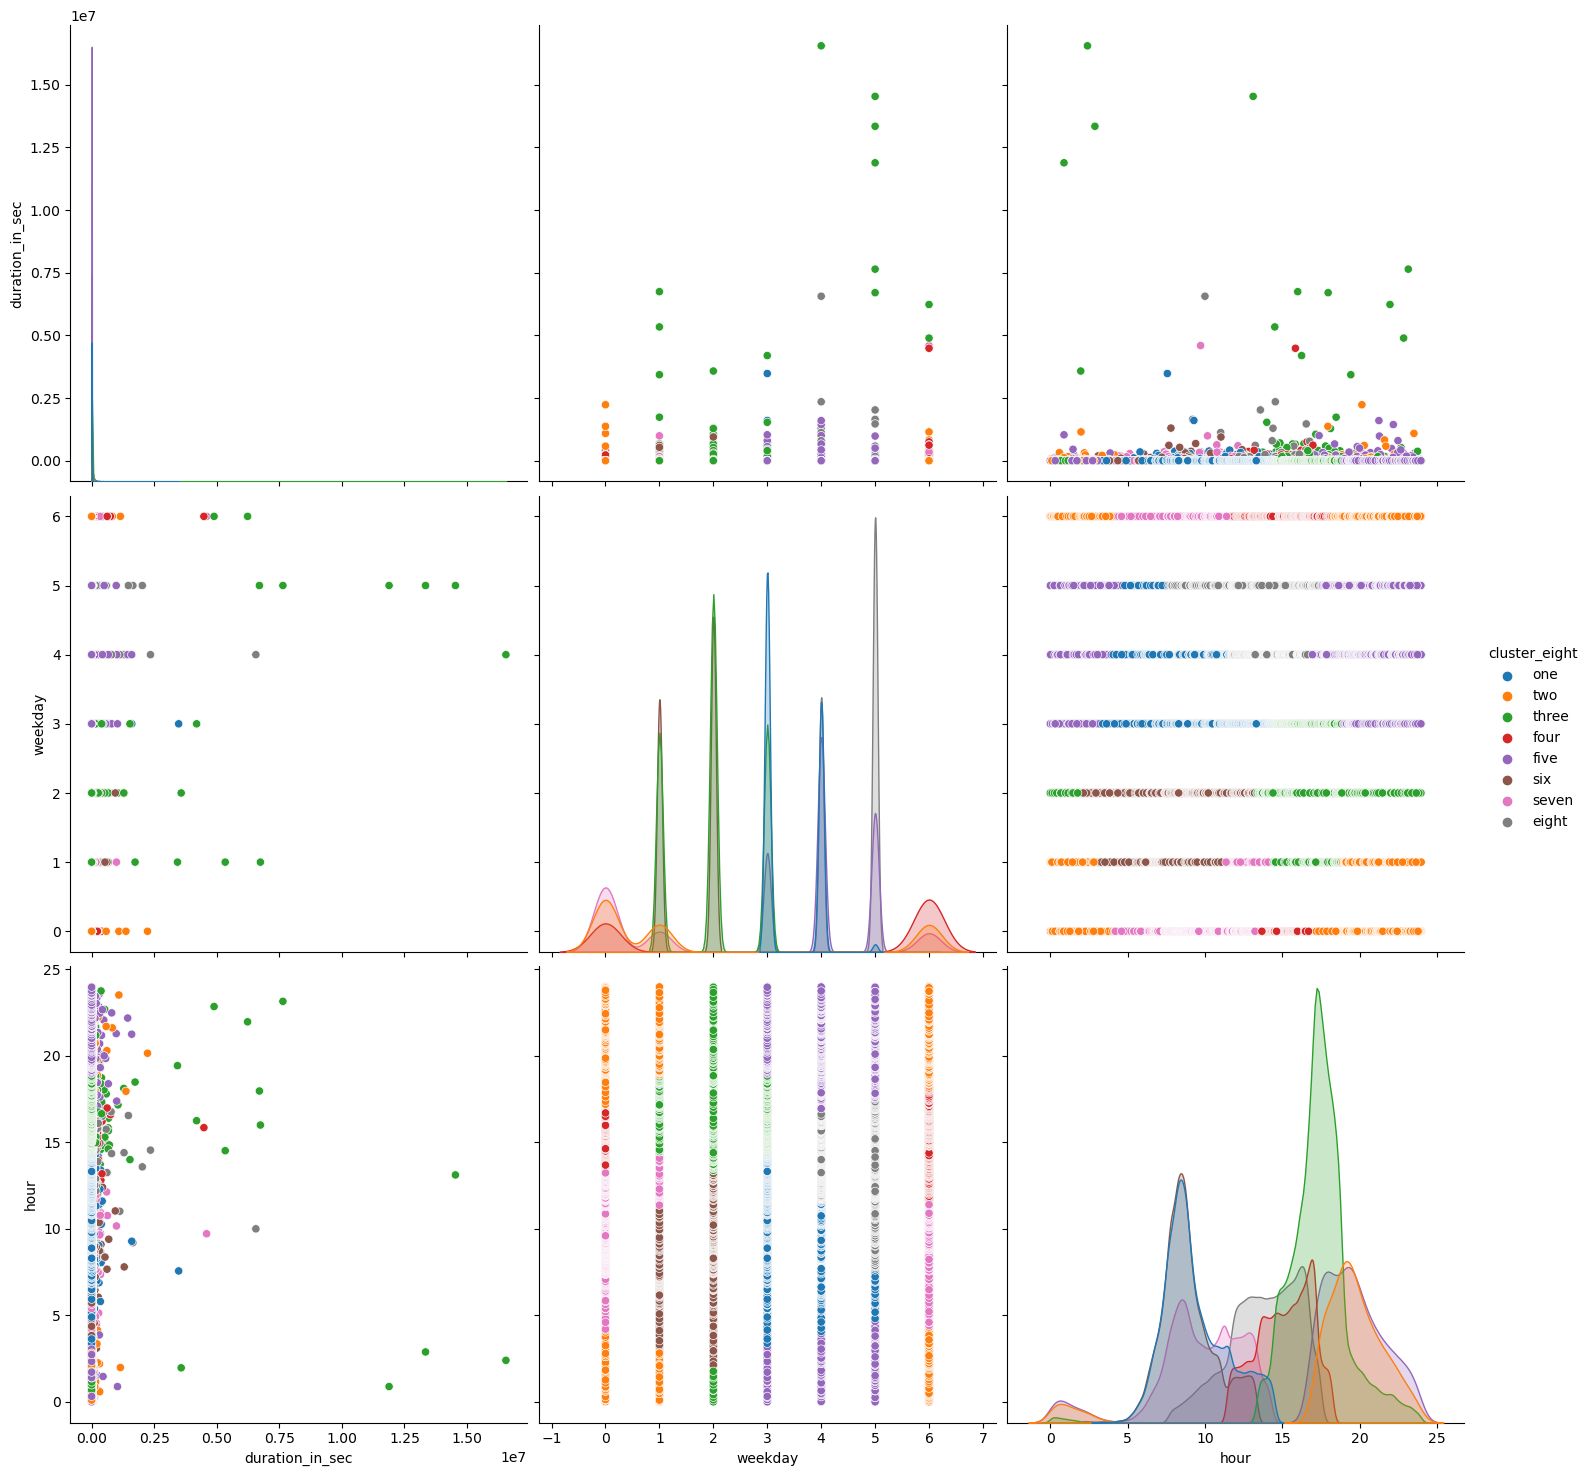

In [108]:
g = sns.pairplot(data=trip_types_scaled, hue="cluster_eight", hue_order=numbers, 
                 height=5, vars=["duration_in_sec","weekday","hour"])

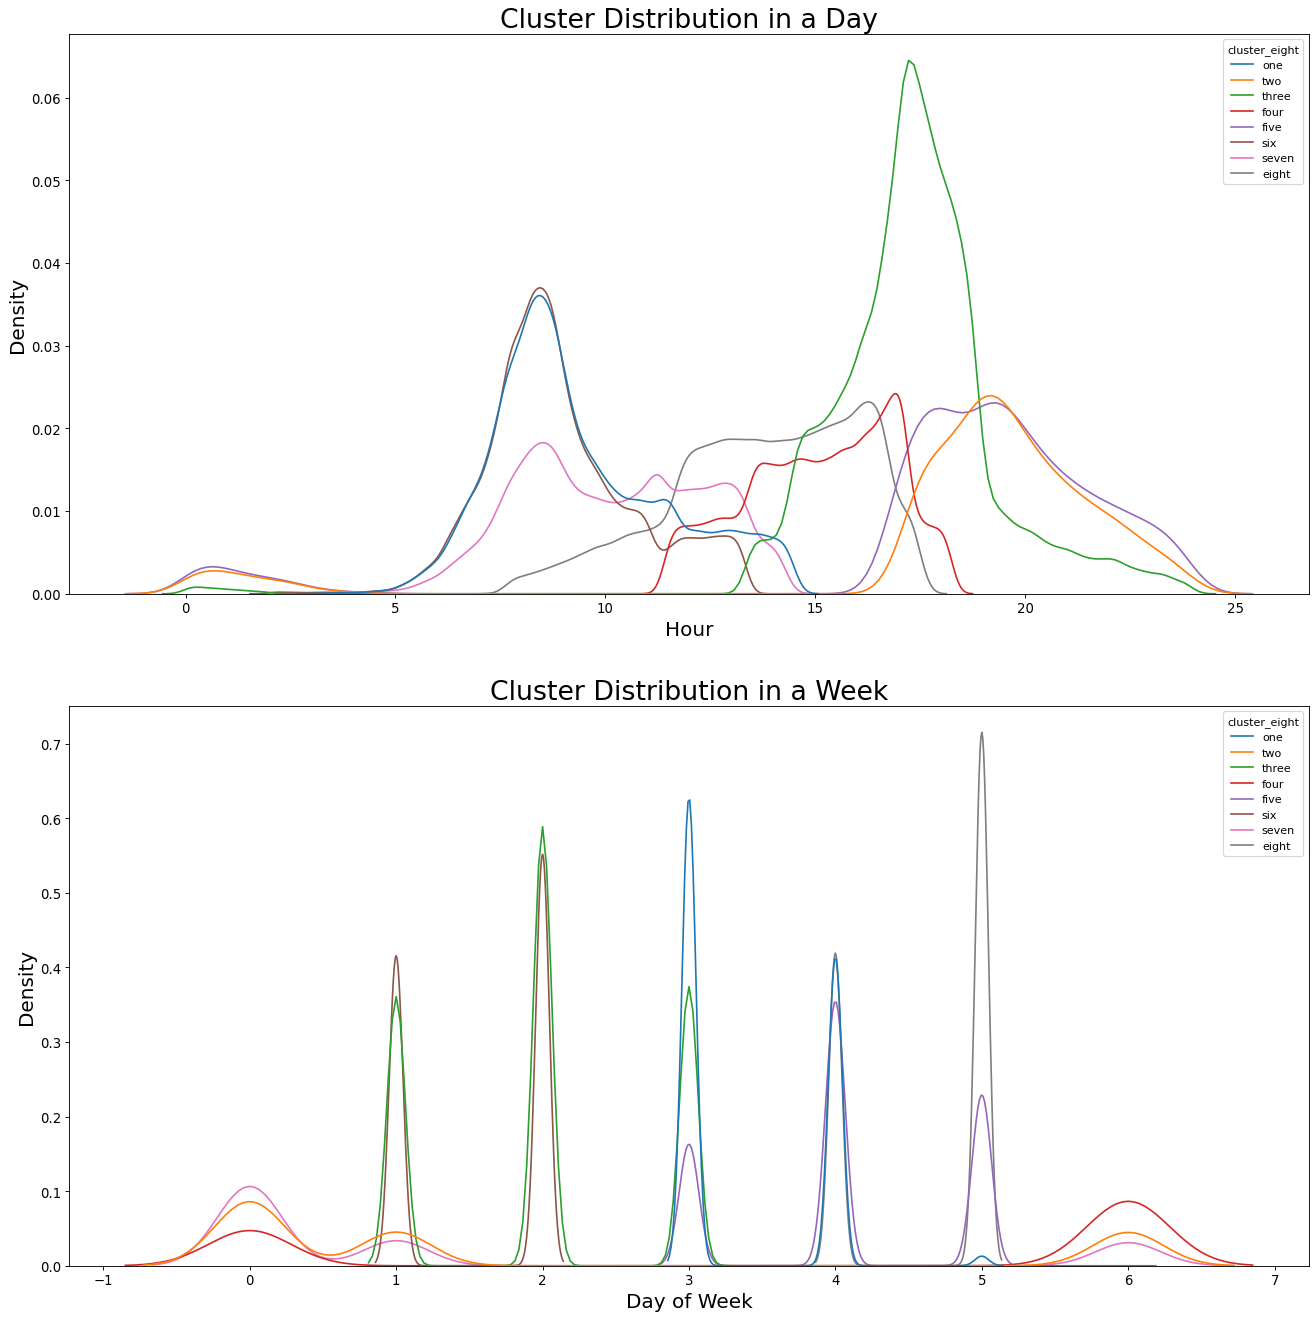

In [114]:
fig,ax = plt.subplots(2,1,figsize=(20,20), dpi= 80) 
axis_font = {'size':'18'}
label_font = {'labelsize':'12'}
dic={'fontsize': '24'}

sns.kdeplot(data=trip_types_scaled, x="hour", hue="cluster_eight",hue_order=numbers, ax=ax[0])
sns.kdeplot(data=trip_types_scaled, x="weekday", hue="cluster_eight",hue_order=numbers, ax=ax[1])


ax[0].set_title("Cluster Distribution in a Day", dic)
ax[0].set_ylabel("Density", **axis_font)
ax[0].set_xlabel("Hour", **axis_font)
ax[0].tick_params(axis='both', **label_font)

ax[1].set_title("Cluster Distribution in a Week", dic)
ax[1].set_ylabel("Density", **axis_font)
ax[1].set_xlabel("Day of Week", **axis_font)
ax[1].tick_params(axis='both', **label_font)

plt.show()

clusters:
- one (blue): peaks during morning between 5 and 10 am, lowers slowly from 10 to 15 but only mid week -> travelling to work midweek
- two (orange): peaks in the evening and during night time 5pm till 2am only during the weekend -> party, going out on the weekend
- three (green): peaks from afternoon early till evening and lowers down till night time, also exceptionally long trips -> afterwork, freetime
- four (red): peaks from late morning till late afternoon but only on weekends -> daytrips, weekend trips during the day
- five (purple): peaks in the evening and during night time 5pm till 2am but only mid week -> afterwork bar, party
- six (brown): peaks during morning between 5 and 10 am, lowers slowly from 10 to 15 but only early in the week -> travelling to work early in the week 
- seven (pink): peaks during early morning and early afternoon but only on weekends -> brunch, early trips on the weekend
- eight (grey): peaks from late morning till late afternoon but only on fridays -> ?
